# Covid19 Tweets Sentiment Prediction
### Group Member: Fangyu Lo, Qing Gong

### 1. Load data and packages

In [1]:
# Load Packages
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib as mpl
import os
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import re

from collections import Counter
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

mpl.rcParams["figure.dpi"] = 100
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("Corona_NLP_train.csv")
df_test = pd.read_csv("Corona_NLP_test.csv")

In [3]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].astype(str)
df_train['Sentiment'] = df_train['Sentiment'].astype(str)

df_test['OriginalTweet'] = df_test['OriginalTweet'].astype(str)
df_test['Sentiment'] = df_test['Sentiment'].astype(str)

In [4]:
df = pd.concat([df_train,df_test])

In [5]:
train = df_train[['OriginalTweet']]
test = df_test[['OriginalTweet']]

In [6]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### 2. Exploratory Data Analysis & Data Visualization

In [8]:
# check data info
print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))
print("\n")
print(df_train.info())

Training Set Shape = (41157, 6)
Test Set Shape = (3798, 6)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


In [9]:
# check sentiment distribution
df.groupby('Sentiment').count()

,UserName,ScreenName,Location,TweetAt,OriginalTweet
Sentiment,,,,,
Extremely Negative,6073,6073,4698,6073,6073
Extremely Positive,7223,7223,5755,7223,7223
Negative,10958,10958,8574,10958,10958
Neutral,8332,8332,6669,8332,8332
Positive,12369,12369,9835,12369,12369


In [10]:
class_df = df.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='autumn')

,Sentiment,OriginalTweet
4,Positive,12369
2,Negative,10958
3,Neutral,8332
1,Extremely Positive,7223
0,Extremely Negative,6073


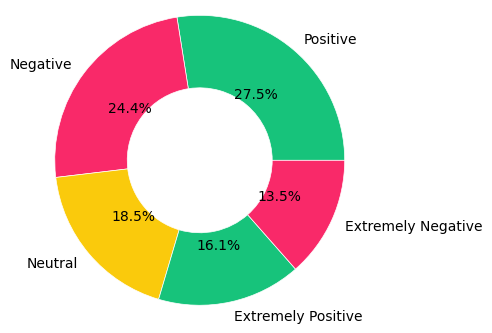

In [11]:
percent_class=class_df.OriginalTweet
labels= class_df.Sentiment
colors = ['#17C37B','#F92969','#FACA0C']
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")
plt.setp(my_pie, width=0.6, edgecolor='white') 
plt.show()

We can see that classes are unevenly distributed.
The largest of the pie is composed with positive, followed by negatives.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Extremely Negative'),
  Text(1, 0, 'Extremely Positive'),
  Text(2, 0, 'Negative'),
  Text(3, 0, 'Neutral'),
  Text(4, 0, 'Positive')])

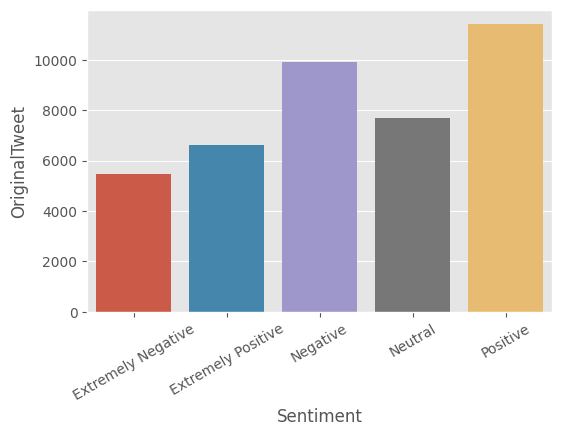

In [12]:
class_df = df_train.groupby('Sentiment').count()['OriginalTweet'].reset_index()
sns.barplot(data = class_df, x = 'Sentiment', y = 'OriginalTweet')
plt.xticks(rotation=30)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Extremely Negative'),
  Text(1, 0, 'Extremely Positive'),
  Text(2, 0, 'Negative'),
  Text(3, 0, 'Neutral'),
  Text(4, 0, 'Positive')])

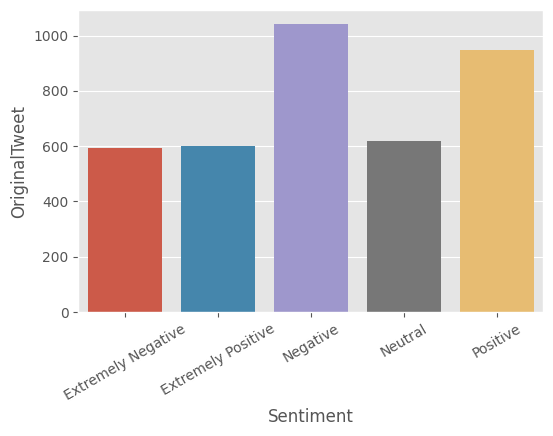

In [13]:
class_df = df_test.groupby('Sentiment').count()['OriginalTweet'].reset_index()
sns.barplot(data = class_df, x = 'Sentiment', y = 'OriginalTweet')
plt.xticks(rotation=30)

We can see that test set has a higher proportion of negative tweets, comparing to train set.

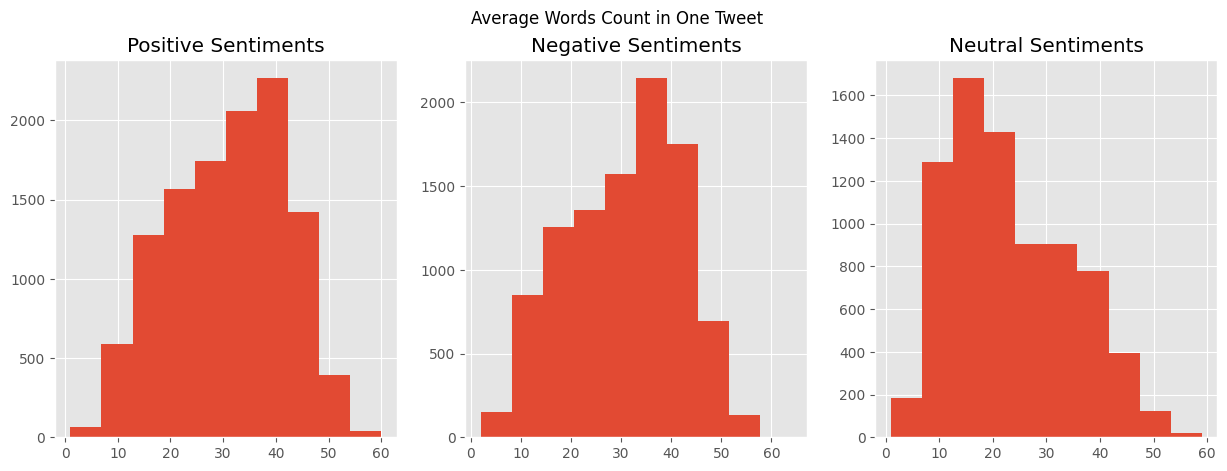

In [14]:
# check average wrods
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df_train[df_train['Sentiment']=="Positive"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len)
ax1.set_title('Positive Sentiments')


tweet_len=df_train[df_train['Sentiment']=="Negative"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len)
ax2.set_title('Negative Sentiments')

tweet_len=df_train[df_train['Sentiment']=="Neutral"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len)
ax3.set_title('Neutral Sentiments')

fig.suptitle('Average Words Count in One Tweet')
plt.show()

### 3. Pre-Process

In [20]:
# preprocess data
def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["OriginalTweet"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        stemmer = PorterStemmer()
        filtered_words = [stemmer.stem(w) for w in filtered_words]
        preprocessed_sentences.append(" ".join(filtered_words))
    df["OriginalTweet"] = preprocessed_sentences
    return df


In [21]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

In [22]:
train_pre = train['OriginalTweet']
test_pre = test['OriginalTweet']
train_pre = train_pre.apply(data_cleaner)
test_pre = test_pre.apply(data_cleaner)


In [23]:
clean_train = train.copy()
clean_test = test.copy()

clean_train.OriginalTweet = train_pre
clean_test.OriginalTweet = test_pre

In [26]:
w2v_train = preprocess_df(clean_train)
w2v_test = preprocess_df(clean_test)

In [28]:
w2v_train = [word_tokenize(_d) for i, _d in enumerate(w2v_train.OriginalTweet)]
w2v_test = [word_tokenize(_d) for i, _d in enumerate(w2v_test.OriginalTweet)]

### 4. Model Building and Training

### 1. Word2Vec model

In [157]:
# Word2Vec model

w2v_model = Word2Vec(min_count=50,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=12)
w2v_model.build_vocab(w2v_train, progress_per=10000)
w2v_model.train(w2v_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

In [158]:
cal = []
for i in range(len(w2v_train)):
    matrix = []
    for w in w2v_train[i]:
        if w in w2v_model.wv.vocab:
            matrix.append(w2v_model.wv[w])
    if len(matrix) != 0:
        cal.append((sum(matrix)/len(matrix)))
    else:
        cal.append(np.NaN)
df_train['w2v_vec'] = cal

cal = []
for i in range(len(w2v_test)):
    matrix = []
    for w in w2v_test[i]:
        if w in w2v_model.wv.vocab:
            matrix.append(w2v_model.wv[w])
    if len(matrix) != 0:
        cal.append((sum(matrix)/len(matrix)))
    else:
        cal.append(np.NaN)
df_test['w2v_vec'] = cal

In [159]:
#train input
dimen = 200
cal_n = 0
for i in range(len(df_train)):
    if cal_n == 0:
        if type(df_train['w2v_vec'].iloc[i]) == np.ndarray:
            cal_df_train = pd.DataFrame(df_train['w2v_vec'].iloc[i]).T
            cal_n = 1
        else:
            cal_df_train = pd.DataFrame([0] * dimen).T
            cal_n = 1

    else:
        if type(df_train['w2v_vec'].iloc[i]) == np.ndarray:#.shape == (100,):
            data = pd.DataFrame(df_train['w2v_vec'].iloc[i]).T
            cal_df_train = pd.concat([cal_df_train, data])
        else:
            data = pd.DataFrame([0] * dimen).T
            cal_df_train = pd.concat([cal_df_train, data])

In [160]:
#test input
cal_n = 0
for i in range(len(df_test)):
    if cal_n == 0:
        if type(df_test['w2v_vec'].iloc[i]) == np.ndarray:
            cal_df_test = pd.DataFrame(df_test['w2v_vec'].iloc[i]).T
            cal_n = 1
        else:
            cal_df_test = pd.DataFrame([0] * dimen).T
            cal_n = 1

    else:
        if type(df_test['w2v_vec'].iloc[i]) == np.ndarray:#.shape == (100,):
            data = pd.DataFrame(df_test['w2v_vec'].iloc[i]).T
            cal_df_test = pd.concat([cal_df_test, data])
        else:
            data = pd.DataFrame([0] * dimen).T
            cal_df_test = pd.concat([cal_df_test, data])

#### 5-label Word2Vec

In [ ]:
X_train = cal_df_train.values
y_train = df_train['Sentiment'].values
X_test = cal_df_test.values
y_test = df_test['Sentiment'].values

In [27]:
from sklearn.linear_model import LogisticRegressionCV

C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.6min remaining: 20.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.0min finished


0.4228541337546077

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_predict = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict, average='micro')))

Accuracy score: 0.4228541337546077
Macro-f1 score:0.4173502047716788
Micro-f1 score:0.4228541337546076


In [39]:
print(classification_report(y_test,y_predict))

                    precision    recall  f1-score   support

Extremely Negative       0.49      0.26      0.34       592
Extremely Positive       0.59      0.26      0.36       599
          Negative       0.38      0.44      0.41      1041
           Neutral       0.45      0.44      0.45       619
          Positive       0.33      0.50      0.40       947

          accuracy                           0.40      3798
         macro avg       0.45      0.38      0.39      3798
      weighted avg       0.43      0.40      0.39      3798



#### 3-label Word2Vec

In [171]:
encoding = {'Extremely Negative': 'Negative',
            'Extremely Positive': 'Positive'
           }
labels = ['Negative', 'Neutral', 'Positive']
X_train = cal_df_train.values
y_train = df_train[['Sentiment']].replace(encoding)['Sentiment'].values
X_test = cal_df_test.values
y_test = df_test[['Sentiment']].replace(encoding)['Sentiment'].values


In [172]:
from sklearn.linear_model import LogisticRegressionCV

C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.8min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.2min finished


0.6537651395471301

In [173]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_predict = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict, average='micro')))

Accuracy score: 0.6537651395471301
Macro-f1 score:0.6118022783435241
Micro-f1 score:0.6537651395471301


In [174]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

    Negative       0.68      0.69      0.68      1633
     Neutral       0.58      0.40      0.47       619
    Positive       0.65      0.72      0.68      1546

    accuracy                           0.65      3798
   macro avg       0.63      0.60      0.61      3798
weighted avg       0.65      0.65      0.65      3798



### 2. GloVe twitter 200d

#### 5-label GloVe

In [176]:
# GloVe
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.twitter.27B.200d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

In [177]:
#GloVe Model
cal = []
for i in range(len(w2v_train)):
    matrix = []
    for w in w2v_train[i]:
        if w in model.wv.vocab:
            matrix.append(model.wv[w])
    if len(matrix) != 0:
        cal.append((sum(matrix)/len(matrix)))
    else:
        cal.append(np.NaN)
df_train['Glo_vec'] = cal

cal = []
for i in range(len(w2v_test)):
    matrix = []
    for w in w2v_test[i]:
        if w in model.wv.vocab:
            matrix.append(model.wv[w])
    if len(matrix) != 0:
        cal.append((sum(matrix)/len(matrix)))
    else:
        cal.append(np.NaN)
df_test['Glo_vec'] = cal

In [178]:
cal_n = 0
dimen = 200
for i in range(len(df_train)):
    if cal_n == 0:
        if type(df_train['w2v_vec'].iloc[i]) == np.ndarray:
            cal_df_train = pd.DataFrame(df_train['w2v_vec'].iloc[i]).T
            cal_n = 1
        else:
            cal_df_train = pd.DataFrame([0] * dimen).T
            cal_n = 1

    else:
        if type(df_train['Glo_vec'].iloc[i]) == np.ndarray:#.shape == (100,):
            data = pd.DataFrame(df_train['Glo_vec'].iloc[i]).T
            cal_df_train = pd.concat([cal_df_train, data])
        else:
            data = pd.DataFrame([0] * dimen).T
            cal_df_train = pd.concat([cal_df_train, data])

cal_n = 0
for i in range(len(df_test)):
    if cal_n == 0:
        if type(df_test['w2v_vec'].iloc[i]) == np.ndarray:
            cal_df_test = pd.DataFrame(df_test['Glo_vec'].iloc[i]).T
            cal_n = 1
        else:
            cal_df_test = pd.DataFrame([0] * dimen).T
            cal_n = 1

    else:
        if type(df_test['Glo_vec'].iloc[i]) == np.ndarray:#.shape == (100,):
            data = pd.DataFrame(df_test['Glo_vec'].iloc[i]).T
            cal_df_test = pd.concat([cal_df_test, data])
        else:
            data = pd.DataFrame([0] * dimen).T
            cal_df_test = pd.concat([cal_df_test, data])

In [32]:
X_train = cal_df_train.values
y_train = df_train['Sentiment'].values
X_test = cal_df_test.values
y_test = df_test['Sentiment'].values

In [33]:
C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


0.4370721432332807

In [34]:
y_predict_g = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict_g)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict_g, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict_g, average='micro')))


Accuracy score: 0.4370721432332807
Macro-f1 score:0.43481863677876686
Micro-f1 score:0.4370721432332807


In [35]:
print(classification_report(y_test,y_predict_g))

                    precision    recall  f1-score   support

Extremely Negative       0.53      0.31      0.39       592
Extremely Positive       0.63      0.33      0.43       599
          Negative       0.41      0.44      0.43      1041
           Neutral       0.46      0.50      0.48       619
          Positive       0.38      0.53      0.44       947

          accuracy                           0.44      3798
         macro avg       0.48      0.42      0.43      3798
      weighted avg       0.46      0.44      0.43      3798



#### 3-label GloVe

In [179]:
encoding = {'Extremely Negative': 'Negative',
            'Extremely Positive': 'Positive'
           }
labels = ['Negative', 'Neutral', 'Positive']
X_train = cal_df_train.values
y_train = df_train[['Sentiment']].replace(encoding)['Sentiment'].values
X_test = cal_df_test.values
y_test = df_test[['Sentiment']].replace(encoding)['Sentiment'].values


In [180]:
C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


0.6521853607161664

In [181]:
y_predict_g = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict_g)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict_g, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict_g, average='micro')))


Accuracy score: 0.6521853607161664
Macro-f1 score:0.6065921781554265
Micro-f1 score:0.6521853607161664


In [182]:
print(classification_report(y_test,y_predict_g))

              precision    recall  f1-score   support

    Negative       0.70      0.68      0.69      1633
     Neutral       0.52      0.39      0.45       619
    Positive       0.65      0.73      0.68      1546

    accuracy                           0.65      3798
   macro avg       0.62      0.60      0.61      3798
weighted avg       0.65      0.65      0.65      3798



### 3. tf-idf

#### 5-label tf-idf

In [183]:
clean_train.OriginalTweet = train_pre
clean_test.OriginalTweet = test_pre
w2v_train = preprocess_df(clean_train)
#w2v_train = [word_tokenize(_d) for i, _d in enumerate(w2v_train.OriginalTweet)]

w2v_test = preprocess_df(clean_test)
#w2v_test = [word_tokenize(_d) for i, _d in enumerate(w2v_test.OriginalTweet)]

In [184]:
X = pd.concat([clean_train, clean_test])

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,  # applied preprocessor in Data Cleaning
                        tokenizer=word_tokenize,
                        use_idf=True,
                        min_df=50,
                        norm='l2',
                        smooth_idf=True)

df_tfidf = []
for i in range(len(X)):
    sen = X.OriginalTweet.iloc[i]
    df_tfidf.append(sen)
    
df_tfidf = tfidf.fit_transform(df_tfidf)

In [186]:
X_train = df_tfidf[:41157]
X_test = df_tfidf[41157:]
print(X_test.shape)
#tfidf.get_feature_names()

(3798, 1916)


In [ ]:
y_train = df_train['Sentiment'].values
y_test = df_test['Sentiment'].values

In [46]:
C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


0.6295418641390206

In [47]:
y_predict_g = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict_g)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict_g, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict_g, average='micro')))


Accuracy score: 0.6295418641390206
Macro-f1 score:0.6411512636702114
Micro-f1 score:0.6295418641390206


In [48]:
print(classification_report(y_test,y_predict_g))

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.60      0.63       592
Extremely Positive       0.73      0.66      0.69       599
          Negative       0.58      0.55      0.57      1041
           Neutral       0.69      0.76      0.72       619
          Positive       0.57      0.63      0.60       947

          accuracy                           0.63      3798
         macro avg       0.64      0.64      0.64      3798
      weighted avg       0.63      0.63      0.63      3798



#### 3-label tf-idf

In [ ]:
encoding = {'Extremely Negative': 'Negative',
            'Extremely Positive': 'Positive'
           }
labels = ['Negative', 'Neutral', 'Positive']
y_train = df_train[['Sentiment']].replace(encoding)['Sentiment'].values
y_test = df_test[['Sentiment']].replace(encoding)['Sentiment'].values


In [187]:
C_test = list(np.power(10.0, np.arange(-10, 10)))
clf = LogisticRegressionCV(cv=5,
                            Cs=C_test,
                            scoring='accuracy',
                           random_state=42,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=100000000).fit(X_train, y_train)

#accuracy score for the list of floats
clf.score(X_test, y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.4s remaining:   38.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


0.7996313849394419

In [188]:
y_predict_g = clf.predict(X_test) #using train + validation data to predict test data
print('Accuracy score: ' + str(accuracy_score(y_test, y_predict_g)))
print('Macro-f1 score:' + str(f1_score(y_test, y_predict_g, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, y_predict_g, average='micro')))


Accuracy score: 0.7996313849394419
Macro-f1 score:0.7835826031428249
Micro-f1 score:0.7996313849394419


In [189]:
print(classification_report(y_test,y_predict_g))

              precision    recall  f1-score   support

    Negative       0.83      0.80      0.81      1633
     Neutral       0.71      0.73      0.72       619
    Positive       0.81      0.83      0.82      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.79      0.78      3798
weighted avg       0.80      0.80      0.80      3798



### 4. Tensorflow Keras

#### 3-label Keras

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [16]:
train = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')

In [140]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [141]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [142]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(X[6]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 36117

Example:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1174, 7, 4, 1269, 761, 65, 2902, 9761, 9762, 154, 18316, 1501, 2, 62, 154, 900, 958]

After padding :
[ 1174     7     4  1269   761    65  2902  9761  9762   154 18316  1501
     2    62   154   900   958     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [134]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
labels = ['Negative', 'Neutral', 'Positive']
y.replace(encoding, inplace=True)


In [21]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            577872    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [22]:
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 304s 266ms/step - loss: 0.8472 - accuracy: 0.5791 - val_loss: 0.3935 - val_accuracy: 0.8631
Epoch 2/2
1132/1132 [==============================] - 291s 257ms/step - loss: 0.3401 - accuracy: 0.8903 - val_loss: 0.3644 - val_accuracy: 0.8739


In [23]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')
y_test.replace(encoding, inplace=True)
pred = model.predict_classes(X_test)

In [24]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print(classification_report(y_test, pred, target_names=labels))

Test loss: 0.4222216010093689
Test Accuracy: 0.8491311073303223
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      1633
     Neutral       0.89      0.75      0.82       619
    Positive       0.84      0.88      0.86      1546

    accuracy                           0.85      3798
   macro avg       0.86      0.83      0.84      3798
weighted avg       0.85      0.85      0.85      3798



In [26]:
from sklearn.metrics import f1_score

print('Macro-f1 score:' + str(f1_score(y_test, pred, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, pred, average='micro')))


Macro-f1 score:0.8423643812689598
Micro-f1 score:0.84913112164297


#### 5-label Keras

In [145]:
encoding = {'Extremely Negative': 0,
            'Negative':1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4
           }
labels = ['Extremely Negative','Negative', 'Neutral', 'Positive', 'Extremely Positive']
y.replace(encoding, inplace=True)

tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(5)
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )
model.summary()

history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            577872    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [146]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')
y_test.replace(encoding, inplace=True)
pred_1 = model.predict_classes(X_test)

In [149]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print(classification_report(y_test, pred_1, target_names=labels))
print('Macro-f1 score:' + str(f1_score(y_test, pred_1, average='macro')))
print('Micro-f1 score:' + str(f1_score(y_test, pred_1, average='micro')))


Test loss: 0.7092971205711365
Test Accuracy: 0.7509215474128723
                    precision    recall  f1-score   support

Extremely Negative       0.80      0.67      0.73       592
          Negative       0.68      0.75      0.71      1041
           Neutral       0.88      0.82      0.85       619
          Positive       0.69      0.77      0.73       947
Extremely Positive       0.84      0.73      0.78       599

          accuracy                           0.75      3798
         macro avg       0.78      0.75      0.76      3798
      weighted avg       0.76      0.75      0.75      3798

Macro-f1 score:0.7606459329295701
Micro-f1 score:0.7509215376513955


### 5. Model Comparison

We evaluated the model performance based on accuracy rate, macro F1-score, and micro F1-score. The neural network performed the best on both the five-label model and three-label model with accuracy rates of 0.75 and 0.85. The TF-IDF embedding method brought the greatest performance for the logistic regression, 0.63 accuracy rate for the five-label model and 0.8 accuracy rate for the three-label model. The logistic regression for the Word2Vec and GloVe models had similar performances within each of the five-label and three-label models. 

Overall, we can see an increase in accuracy rate and F1-score when we moved from the five-label model to the three-label model. It is reasonable since the models would not need to distinguish between extremely negative tweets and negative tweets as well as extremely positive tweets and positive tweets.

### 6. Sentiment trend

In [96]:
df_all = pd.concat([train,test])
df_all = df_all.replace({'Location':{'USA':'United States', 
                                     'New York, USA':'NY', 
                                     'London':'London, England', 
                                     'UK':'United Kingdom', 
                                     'England, United Kingdom':'United Kingdom', 
                                     'London, UK':'London, England', 
                                     'New York':'NY', 
                                     'New York City':'NY', 
                                     'Los Angeles':'CA', 
                                     'Los Angeles, CA':'CA',
                                     'Worldwide':'Global', 
                                     'Washington, D.C.':'DC', 
                                     'NYC':'NY', 
                                     'Brooklyn, NY':'NY', 
                                     'New York, NY': 'NY', 
                                     'Washington, DC':'DC', 
                                     'San Francisco, CA':'CA',
                                     'California, USA':'CA', 
                                     'San Diego, CA':'CA', 
                                     'California':'CA', 
                                     'Sacramento, CA':'CA', 
                                     'San Francisco':'CA', 
                                     'San Jose, CA': 'CA', 
                                     'Oakland, CA':'CA', 
                                     'Manhattan, NY':'NY', 
                                     'Washington DC':'DC', 
                                     'Bronx, NY':'NY', 
                                     'San Francisco Bay Area':'CA', 
                                     'London, United Kingdom':'London, England', 
                                     'Rochester, NY':'NY', 
                                     'Berkeley, CA':'CA', 
                                     'Queens, NY':'NY', 
                                     'New York, New York':'NY', 
                                     'US':'United States', 
                                     'Long Beach, CA':'CA', 
                                     'Santa Barbara, CA':'CA', 
                                     'City of London, London':'London, England'}})
df_all.groupby('Location')[['Sentiment']].count().sort_values(by='Sentiment',ascending = False).head(10)

,Sentiment
Location,
"London, England",1266
CA,1114
NY,1058
United States,860
United Kingdom,802
DC,538
India,283
Global,271
Australia,236


In [99]:
location_data = df_all[(df_all.Location == 'London, England')|(df_all.Location == 'CA')| (df_all.Location == 'NY')]
location_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,"London, England",16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
25,3824,48776,"London, England",16-03-2020,UK #consumer poll indicates the majority expec...,Extremely Positive
28,3827,48779,NY,16-03-2020,Do you see malicious price increases in NYC? T...,Negative
34,3833,48785,"London, England",16-03-2020,We're sorry to say that our @FinFabUK event is...,Negative
67,3866,48818,"London, England",16-03-2020,@BobJLowe Sadly those are the misinformed thin...,Negative
...,...,...,...,...,...,...
3750,3751,48703,CA,16-03-2020,Latest list of #retailers temporarily closing ...,Neutral
3755,3756,48708,NY,16-03-2020,Yes your money is covered in germs No isn t ma...,Neutral
3759,3760,48712,CA,16-03-2020,?@NYSE? + ?@Nasdaq? Need to Be Temporarily Clo...,Negative
3764,3765,48717,CA,16-03-2020,No toilet paper at Trader Joe's; employee said...,Positive


In [101]:
location_data.Sentiment.unique()

array(['Neutral', 'Extremely Positive', 'Negative', 'Positive',
       'Extremely Negative'], dtype=object)

In [112]:
location_data['TweetAt'] = pd.to_datetime(location_data['TweetAt'])
sort_loc = location_data.groupby(['Location','TweetAt', 'Sentiment'])['UserName'].count().reset_index().rename(columns={'UserName':'TweetCount'})
neg = sort_loc[sort_loc['Sentiment'] == 'Extremely Negative']
neg

,Location,TweetAt,Sentiment,TweetCount
4,CA,2020-02-04,Extremely Negative,1
10,CA,2020-03-04,Extremely Negative,1
15,CA,2020-03-13,Extremely Negative,4
20,CA,2020-03-14,Extremely Negative,5
25,CA,2020-03-15,Extremely Negative,4
...,...,...,...,...
454,NY,2020-09-04,Extremely Negative,6
460,NY,2020-10-04,Extremely Negative,6
465,NY,2020-11-03,Extremely Negative,1
468,NY,2020-11-04,Extremely Negative,2


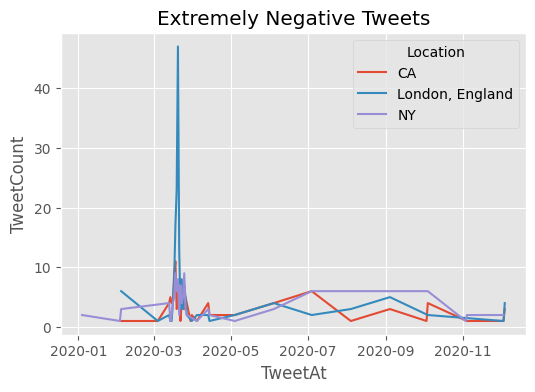

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(y='TweetCount', x='TweetAt',hue='Location', data=neg).set_title('Extremely Negative Tweets')
plt.show()

In [123]:
pos = sort_loc[sort_loc['Sentiment'] == 'Extremely Positive']
pos

,Location,TweetAt,Sentiment,TweetCount
0,CA,2020-01-04,Extremely Positive,3
5,CA,2020-02-04,Extremely Positive,3
11,CA,2020-03-04,Extremely Positive,3
16,CA,2020-03-13,Extremely Positive,1
21,CA,2020-03-14,Extremely Positive,6
...,...,...,...,...
461,NY,2020-10-04,Extremely Positive,6
466,NY,2020-11-03,Extremely Positive,1
469,NY,2020-11-04,Extremely Positive,1
474,NY,2020-12-03,Extremely Positive,2


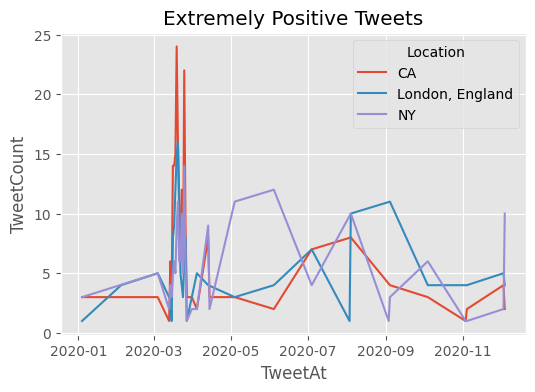

In [124]:
sns.lineplot(y='TweetCount', x='TweetAt',hue='Location', data=pos).set_title('Extremely Positive Tweets')
plt.show()

Text(0.5, 1.0, 'Sentiment Analysis During Covid-19')

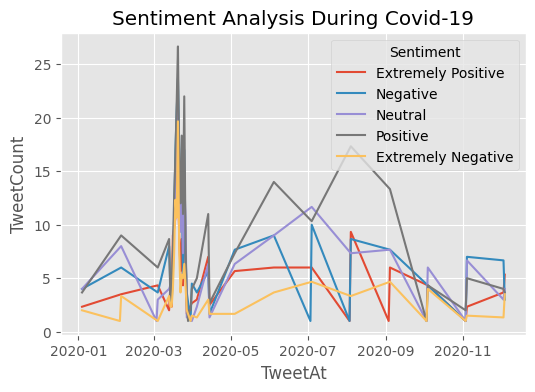

In [125]:
sns.lineplot(y='TweetCount', x='TweetAt',hue='Sentiment', data=sort_loc, ci=None).set_title('Sentiment Analysis During Covid-19')

In [226]:
test['pred_nn'] = pred_1
test['pred_3'] = pred
test['sentiment_number'] = y_test
encoding = {0:'Extremely Negative',
            1:'Negative',
            2:'Neutral',
            3:'Positive',
            4:'Extremely Positive'
           }

encoding_3 = {0:'Negative',
            1:'Neutral',
            2:'Positive'
           }

encoding_back = {'Extremely Negative':'Negative',
                 'Extremely Positive':'Positive'
           }
test['sentiment_pred_5'] = test[['pred_nn']].replace(encoding)['pred_nn']
test['sentiment_pred_3'] = test[['pred_3']].replace(encoding_3)['pred_3']
test['sentiment_3'] = test[['Sentiment']].replace(encoding_back)['Sentiment']


In [227]:
test = test.replace({'Location':{'USA':'United States', 
                                     'New York, USA':'NY', 
                                     'London':'London, England', 
                                     'UK':'United Kingdom', 
                                     'England, United Kingdom':'United Kingdom', 
                                     'London, UK':'London, England', 
                                     'New York':'NY', 
                                     'New York City':'NY', 
                                     'Los Angeles':'CA', 
                                     'Los Angeles, CA':'CA',
                                     'Worldwide':'Global', 
                                     'Washington, D.C.':'DC', 
                                     'NYC':'NY', 
                                     'Brooklyn, NY':'NY', 
                                     'New York, NY': 'NY', 
                                     'Washington, DC':'DC', 
                                     'San Francisco, CA':'CA',
                                     'California, USA':'CA', 
                                     'San Diego, CA':'CA', 
                                     'California':'CA', 
                                     'Sacramento, CA':'CA', 
                                     'San Francisco':'CA', 
                                     'San Jose, CA': 'CA', 
                                     'Oakland, CA':'CA', 
                                     'Manhattan, NY':'NY', 
                                     'Washington DC':'DC', 
                                     'Bronx, NY':'NY', 
                                     'San Francisco Bay Area':'CA', 
                                     'London, United Kingdom':'London, England', 
                                     'Rochester, NY':'NY', 
                                     'Berkeley, CA':'CA', 
                                     'Queens, NY':'NY', 
                                     'New York, New York':'NY', 
                                     'US':'United States', 
                                     'Long Beach, CA':'CA', 
                                     'Santa Barbara, CA':'CA', 
                                     'City of London, London':'London, England'}})
test.groupby('Location')[['Sentiment']].count().sort_values(by='Sentiment',ascending = False).head(10)

,Sentiment
Location,
CA,121
NY,99
United States,97
"London, England",81
DC,53
United Kingdom,42
Canada,29
"Toronto, Ontario",29
Toronto,21


In [239]:
location_data = test[(test.Location == 'London, England')|(test.Location == 'CA')| (test.Location == 'NY')]
location_data['TweetAt'] = pd.to_datetime(location_data['TweetAt'])
sent_test = location_data.groupby(['Location','TweetAt', 'Sentiment'])['UserName'].count().reset_index().rename(columns={'UserName':'TweetCount'})
sent_pred = location_data.groupby(['Location','TweetAt', 'sentiment_pred_5'])['UserName'].count().reset_index().rename(columns={'UserName':'TweetCountPredict', 'sentiment_pred_5':'Sentiment_Pred'})
sent_pred_3 = location_data.groupby(['Location','TweetAt', 'sentiment_pred_3'])['UserName'].count().reset_index().rename(columns={'UserName':'TweetCountPredict', 'sentiment_pred_3':'Sentiment_Pred'})
sent_3 = location_data.groupby(['Location','TweetAt', 'sentiment_3'])['UserName'].count().reset_index().rename(columns={'UserName':'TweetCount', 'sentiment_3':'Sentiment'})

                                                                                                                       

In [240]:
neg_1 = sent_test[sent_test['Sentiment'] == 'Extremely Negative']
neg_pred = sent_pred[sent_pred['Sentiment_Pred'] == 'Extremely Negative']
neg_2 = sent_3[sent_3['Sentiment'] == 'Negative']
neg_pred_3 = sent_pred_3[sent_pred_3['Sentiment_Pred'] == 'Negative']

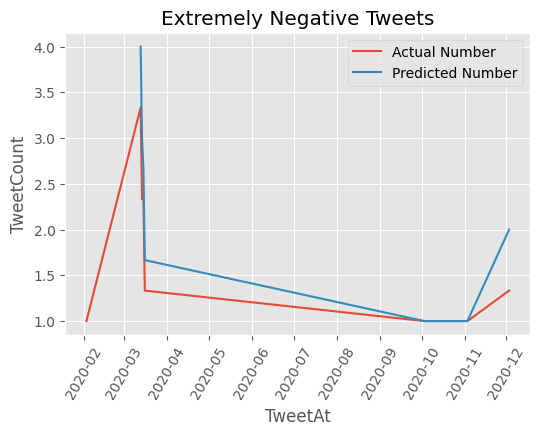

In [236]:
#5 labels
p = sns.lineplot(y='TweetCount', x='TweetAt', data=neg_1, ci=None, label="Actual Number").set_title('Extremely Negative Tweets')
p = sns.lineplot(y='TweetCountPredict', x='TweetAt', data=neg_pred, ci=None, label="Predicted Number").set_title('Extremely Negative Tweets')
plt.xticks(rotation=60)
plt.show()

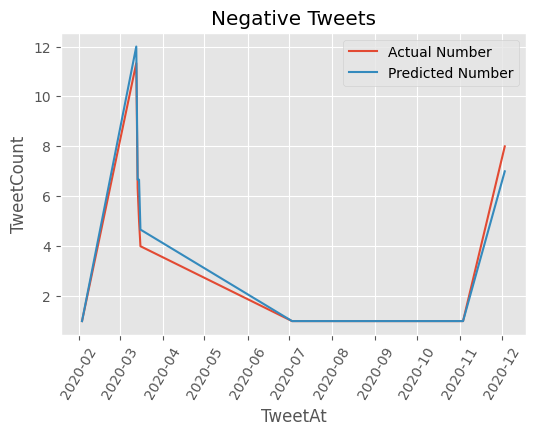

In [241]:
#3 labels
p = sns.lineplot(y='TweetCount', x='TweetAt', data=neg_2, ci=None, label="Actual Number").set_title('Negative Tweets')
p = sns.lineplot(y='TweetCountPredict', x='TweetAt', data=neg_pred_3, ci=None, label="Predicted Number").set_title('Negative Tweets')
plt.xticks(rotation=60)
plt.show()

In [242]:
test.to_csv('test_result.csv')